#**Twitter**


* <h3> Benedikt Mueller 

###1. Introduction
Twitter is a popular microblogging and social network service where users post and interact with messages known as “tweets”. The content of tweets varies from areas of interest, news stories, and general observations to opinions about someone or something. It is these opinions that consumers, marketers and organisations take a keen interest in, as it is a powerful, non-invasive method of researching public opinion in certain areas.

####1.1. Framing the problem.
Prior to starting any machine learning task, it is important to think carefully about the problem you are working on and take time to understand the data. The dataset used contains 5 (id field,date,tweet as string,username and target) columns and 1 million rows of data. The target represents the sentiment of the tweet (0 = negative, 4 = positive).

The main objective of this project is to build a model that classifies tweets according to their sentiment by categorising the opinions expressed in the text to determine if these are positive or negative. Classification Accuracy will be used to evaluate the success of our model against the test data provided. The data is highly unstructured, which is common for most natural language processing (NLP) analyses. It is crucial to spend a fair portion of time to understand, process and restructure the data so that optimal results are achievable.

####1.2 Packages
During the modelling process, the following libraries were used:

*   Pandas: Provides a DataFrame structure to store data in memory and work with it easily and efficiently.
*   NumPy: Provides a fast-numerical array structure and helper functions.
*   Matplotlib, Seaborn: Data visualisation libraries in Python.
*   Keras (with tensorflow backend): High-level library to help develop and train Neural Networks models with ease.
*   Scikit-learn: Mainly used for text processing and basic ML-related tasks.
*   Gensim, bs4, re, nltk: Powerful libraries for any text processing task.

In [ ]:
from IPython.utils import io
from IPython.display import display
with io.capture_output() as captured: #surpresses any output
  import time, os
  import pandas as pd
  import numpy as np
  import seaborn as sns
  import matplotlib.pyplot as plt
  from wordcloud import WordCloud
  from scipy import stats 
  from sklearn.model_selection import train_test_split
  from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
  %matplotlib inline
  from IPython.display import display
  %tensorflow_version 2.x
  import tensorflow as tf
  from tensorflow import keras
  from tensorflow.keras.models import Sequential, load_model
  from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
  from tensorflow.keras.layers import Flatten, Dense, Dropout, Embedding, LSTM,GRU, GlobalMaxPooling1D, SpatialDropout1D, Conv1D,BatchNormalization,MaxPooling1D
  from tensorflow.keras.preprocessing import sequence
  from tensorflow.keras.preprocessing.sequence import pad_sequences
  from tensorflow.keras.utils import to_categorical
  from keras.preprocessing.text import Tokenizer
  %load_ext tensorboard

  from nltk.tokenize import WordPunctTokenizer
  from nltk import word_tokenize
  from nltk.stem import WordNetLemmatizer
  import nltk
  nltk.download('punkt')
  nltk.download('wordnet')
  from bs4 import BeautifulSoup
  import re
  from gensim.models import Word2Vec
print("Loading done!", "\nTensorflow Version: ", tf.__version__)

Loading done! 
Tensorflow Version:  2.2.0-rc2


In [ ]:
#load kaggle token
from google.colab import files
uploaded = files.upload()

In [ ]:
#create instance 
!ls -lha kaggle.json
#!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

###2. Data processing
####2.1 pre-cleaned insights
As shown below, the tweets still contain Emails, punctuations and special characters. Overall, 57% of the tweets are labelled as negative. Almost half of the “tweeters” occur once (or twice). 

In [ ]:
# load training & test datasets
!kaggle competitions download -c cs98x-twitter-sentiment

In [ ]:
# load trainings-set
unlabelled_dataset = pd.read_csv("/content/test.csv.zip")
train = pd.read_csv("/content/training.csv.zip")
train.head(n=6)

,target,id,date,user,text
0,0,2224496154,Thu Jun 18 09:34:25 PDT 2009,Deborah_Fay,Okay for some reason I still can't get the ba...
1,4,1687934301,Sun May 03 09:56:56 PDT 2009,haills,http://twitpic.com/4hjnj - Don't worry be happ...
2,0,1972073814,Sat May 30 08:30:21 PDT 2009,lechellealice,this movie is so sad
3,4,1557632618,Sun Apr 19 05:13:47 PDT 2009,janeslee,Good afternoon world. Been too busy to tweet. ...
4,4,1969750122,Sat May 30 01:05:20 PDT 2009,bvdaily,@QueensleyFelix LOL!We are just too classy I ...
5,4,2046797988,Fri Jun 05 12:42:27 PDT 2009,ianhaha,is with his bubiee


In [ ]:
print("Count:","\n",train.target.value_counts())
print("\nPercentage\n0: ",len(train.target[train.target==0])/len(train.target)*100,"%")
print("4: ",len(train.target[train.target==4])/len(train.target)*100,"%")

Count: 
 0    571361
4    428639
Name: target, dtype: int64

Percentage
0:  57.1361 %
4:  42.8639 %


In [ ]:
print(train.user.value_counts().head())
print("\nPercentage of unique users: ",len(train.user.unique())/len(train.user)*100,"%")

lost_dog           381
tweetpet           228
webwoke            213
mcraddictal        191
SallytheShizzle    174
Name: user, dtype: int64

Percentage of unique users:  48.9091 %


The majority of tweets are between 40 and 110 characters long. The longest seems to have problems with the Unicode translation (example below).

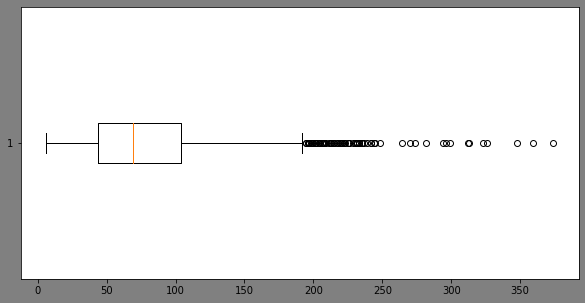

,target,id,date,user,text,pre_clean_len
1884,0,1991367818,Mon Jun 01 06:54:44 PDT 2009,Swiftsure,Too hot,8
647,4,1556549904,Sat Apr 18 23:17:14 PDT 2009,YoMegMarie,Success!,9
1539,0,1834047455,Mon May 18 01:25:34 PDT 2009,FilmTone,Long day,9
1801,0,1751238703,Sat May 09 18:59:17 PDT 2009,Audj4969,headache,9
4423,4,2048179655,Fri Jun 05 14:47:14 PDT 2009,adamy,@thanr à¹à¸à¸µà¹à¸¢à¸§à¹à¸­à¸²à¸£à¸²à¸à¸²...,326
894920,0,2237729497,Fri Jun 19 06:16:15 PDT 2009,spinesurgeon,human shield à®à®©à¯?à®± à®à¯à®±à¯?à®¤à¯à®...,348
94498,0,2052585042,Sat Jun 06 01:14:42 PDT 2009,Incognito_me,@neospace à¹à¸£à¸·à¹à¸­à¸à¸à¸±à¹à¸à¸à¸£...,359
516216,4,2003659618,Tue Jun 02 06:55:50 PDT 2009,GuroGreenBlooD,@catfish_ohm à¹à¸à¹à¸²à¹à¸«à¹à¸?à¸²à¸£à¹...,374


In [ ]:
# count characters
train['pre_clean_len'] = [len(t) for t in train.text]  #.text.apply(lambda p: len(p.split(' ')))
fig, ax = plt.subplots(figsize=(10,5),facecolor="grey")
plt.boxplot(train.pre_clean_len,vert=False)
plt.show()
# 4 highest and lowest
pd.concat([train[(train.pre_clean_len < 10)].head(4).sort_values("pre_clean_len",ascending=True), train[(train.pre_clean_len > 140)].sort_values("pre_clean_len").tail(4)])

####2.2 Data Cleansing
After observing some issues with unstructured texts, it is time to deal with them:
- delete usernames, web addresses,
- deal with unicode problems,
- extracting “not” from negations (e.g. isn´t),
- stem words with lemmatisation,
- optional: delete stopwords.

Note: the stopword list was customized to prevent deleting seemingly important words, e.g. “not or against”. 


In [ ]:
tok = WordPunctTokenizer()
wordnet_lemmatizer = WordNetLemmatizer()
pat1 = r"@[A-Za-z0-9_]+"  # delete after @ (e.g. usernames)
pat2 = r"https?://[^ ]+" # delete web addresses
combined_pat = r'|'.join((pat1, pat2))
www_pat = r"www.[^ ]+" # delete web addresses

# extract not out of words below
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not", "ain't":"am not", "don t":"do not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner(text_df):
  clean_tweet_texts = []
  for i in range(0,len(text_df)):
    text = text_df[i]
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    # catch and solve ocurring error with unicode
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    # apply definitions from above to remove pattern
    stripped = re.sub(combined_pat, '', bom_removed) 
    stripped = re.sub(www_pat, '', stripped) 
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    

    # tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    # extract stem of words
    words_lemma = [wordnet_lemmatizer.lemmatize(x) for x in words]
    clean_tweet_texts.append((" ".join(words_lemma)).strip())
  return clean_tweet_texts

# create own stopword list to keep negations and other maybe helpful stuff
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd",
             'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself',
             'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 
             'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has',
             'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
             'while', 'of', 'at', 'by', 'for', 'with', 'about', 'between', 'through', 'during', 'before', 'after',
             'above', 'below', 'to', 'from', 'under', 'again', 'further', 'then', 'once', 'now', 'd', 'll', 'm', 'o', 're', 've', 'y'
             'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'more', 'most', 'other', 'some', 'such',
             'no', 'own', 'same', 'so', 'than', 's', 't', 'can', 'will', 'should']

# separete stopword removal, see if this helps to improve performance
def stopword_remover(text_df):
  clean_tweet_texts = []
  for i in range(0,len(text_df)):
  #for i in range(0,10):
    text = text_df[i]
    words = np.array(text.split())
    words = [word for word in words if not word in stopwords]
    clean_tweet_texts.append(' '.join(words))
  return clean_tweet_texts

In [ ]:
# example after cleaning
tweet_cleaner(text_df=train.text.loc[:5])

['okay for some reason still can not get the background picture to expand and fill the whole background',
 'do not worry be happy well that all depends on the situation',
 'this movie is so sad',
 'good afternoon world been too busy to tweet washing sewing cleaning lunch at mum in law lovely hope everyones hangover have gone',
 'lol we are just too classy know must ve gotten that from brooke do not even know what the hell im talkin about lol',
 'is with his bubiee']

In [ ]:
# cleaner
cleaned_test = tweet_cleaner(text_df=train.text)

In [ ]:
# stopwords removal
cleaned_test_stopword = stopword_remover(text_df=cleaned_test)

In [ ]:
# grant acces to drive folder
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# safe cleaned dataset
"""clean_df = pd.DataFrame(cleaned_test_stopword,columns=['text'])
clean_df['target'] = train.target
root_path = 'gdrive/My Drive/' 
clean_df.to_csv(root_path + 'cleaned_test_stopword.csv',encoding='utf-8')

####2.3 Data Exploration
After cleaning the dataset, the occurring NaN-fields were dropped (approx. 0.5% without and 0.25% with stopwords).

In [ ]:
# load cleaned df
root_path = 'gdrive/My Drive/' 
my_df = pd.read_csv(root_path + 'cleaned_tweet.csv',index_col=0)
my_df_stop = pd.read_csv(root_path + 'cleaned_tweet_stopword.csv',index_col=0)
print(my_df.info())
#print("\n")
#print(np.sum(my_df[my_df.isnull().any(axis=1)].head()))
my_df.dropna(inplace=True)
my_df.reset_index(drop=True,inplace=True)
my_df_stop.dropna(inplace=True)
my_df_stop.reset_index(drop=True,inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    997510 non-null   object
 1   target  1000000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 22.9+ MB
None


The wordcould shows the most frequent occurring words in the dataset (defined by label, the larger the more frequent, no stopwords). It is interesting to observe, that some words are highly frequent in both, e.g. “today”, “lol”, ”work”. Without further context, there is no way for humans to predict the sentiment. Surprisingly, there is a high occurrence of words which are associated with positive emotions occurring within the negative wordcloud (e.g. “love”, “well”). This is another contextual issue.  

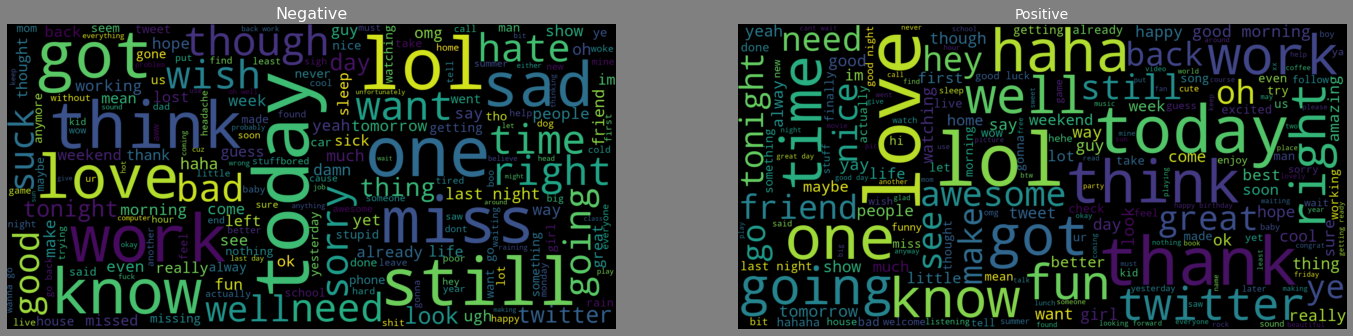

In [ ]:
# fetch all neg (pos) and create a array of all words
neg_tweets = my_df_stop[my_df_stop.target == 0]
neg_string = []
for t in neg_tweets.text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

pos_tweets = my_df_stop[my_df_stop.target == 4]
pos_string = []
for t in pos_tweets.text:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')

# create a wordcloud of the highest freq. words in dataset
fig, ax = plt.subplots(1, 2,figsize=(24,14),facecolor="grey",sharex=False,sharey=False)
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
wordcloud2 = WordCloud(width=1600, height=800,max_font_size=200).generate(pos_string)
ax[0].imshow(wordcloud, interpolation="bilinear")
ax[0].axis("off")
ax[0].set_title('Negative',fontsize=16, color="white")
ax[1].imshow(wordcloud2, interpolation="bilinear")
ax[1].axis("off")
ax[1].set_title('Positive',fontsize=14,color="white")
#fig.suptitle('Wordcloud - without stopwords',fontsize=16, color="white")
#fig.subplots_adjust(top=0.88)
plt.show()

After cleaning, the longest tweet had 34 words without stopwords and 52 with. Most tweets were however shorter (see picture below) with the mean length almost halved. For the following feature engineering approaches, it might be worth considering removing those “outliers”. However, this can also lead to a loss of information in general. It is always a fine line between "over" cleaning and too little. 

In [ ]:
# evaulate character and word length of tweets
phrase_len = my_df.text.apply(lambda p: len(p.split(' ')))
max_phrase_len = phrase_len.max()
my_df["phrase_len"] = phrase_len

phrase_len_stop = my_df_stop.text.apply(lambda p: len(p.split(' ')))
max_phrase_len_stop = phrase_len_stop.max()
my_df_stop["phrase_len"] = phrase_len_stop 

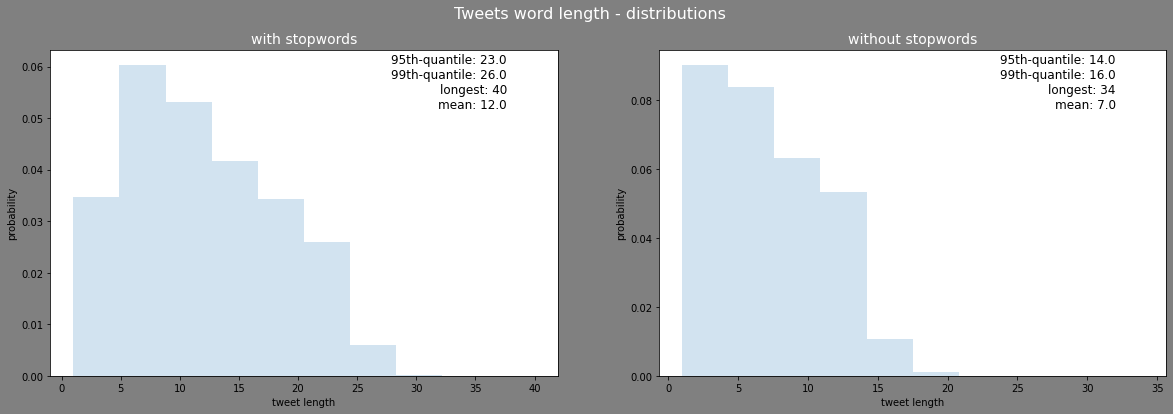

In [ ]:
fig, ax = plt.subplots(1, 2,figsize=(20,6),facecolor="grey",sharex=False,sharey=False)
#plt.figure(facecolor="grey",figsize = (10, 8))
ax[0].hist(phrase_len, alpha = 0.2, density = True)
ax[0].set_xlabel('tweet length')
ax[0].set_ylabel('probability')
ax[0].set_title('with stopwords',fontsize=14,color="white")
text_label = f"95th-quantile: {np.percentile(phrase_len, 95)}\n99th-quantile: {np.percentile(phrase_len, 99)}\
\nlongest: {max_phrase_len}\nmean: {round(np.mean(phrase_len),0)}"
ax[0].text(0.9, 0.9, text_label ,verticalalignment='center',horizontalalignment='right',
           transform=ax[0].transAxes,fontsize=12)
ax[1].hist(phrase_len_stop, alpha = 0.2, density = True)
ax[1].set_xlabel('tweet length')
ax[1].set_ylabel('probability')
ax[1].set_title('without stopwords',fontsize=14,color="white")
text_label = f"95th-quantile: {np.percentile(phrase_len_stop, 95)}\n99th-quantile: {np.percentile(phrase_len_stop, 99)}\
\nlongest: {max_phrase_len_stop}\nmean: {round(np.mean(phrase_len_stop),0)}"
ax[1].text(0.9, 0.9, text_label ,verticalalignment='center',horizontalalignment='right',
           transform=ax[1].transAxes,fontsize=12)
fig.suptitle('Tweets word length - distributions',fontsize=16,color="white")
#fig.subplots_adjust(top=0.88)
plt.show()

In [ ]:
# get rid of outliers if wanted -> restate the max length if so
my_df_outliers = my_df.loc[my_df["phrase_len"]<=26]

### 3. Feature engineering and model testing
Feature engineering is the bread and butter of all machine learning approaches since computers cannot read... obviously.  There are many techniques to translate words in “features” to choose from.

Before applying any technique, the dataset is split into a train, validation and test set (80,10,10), a stratifold split was not enabled.  

In [ ]:
# create split function to call it anytime if changes were made, with seed for reproducability 
def create_splits(df_used):  
  from sklearn.model_selection import train_test_split
  from sklearn.preprocessing import LabelEncoder

  SEED = 1337 
  x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(df_used.text, df_used.target, test_size=.01, random_state=SEED) #80% train   #stratify=my_df.traget
  x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED) #10% test,validation
  # set label to 1,0
  y_train = LabelEncoder().fit_transform(y_train)
  y_validation = LabelEncoder().fit_transform(y_validation)
  y_test = LabelEncoder().fit_transform(y_test)
  return x_train, x_validation, x_test , y_train, y_validation, y_test
x_train, x_validation, x_test , y_train, y_validation, y_test = create_splits(my_df)

In [ ]:
# plot different distributions - if stratify split, then all balanced
print("Dataset ratio: \n0:",round(len(my_df[my_df.target==0])/len(my_df)*100,4), "   4: ",round(len(my_df[my_df.target==1])/len(my_df)*100,4))
print("Trainset ratio: \n0:",round(len(y_train_org[y_train_org==0])/len(y_train_org)*100,4), "   4: ",round(len(y_train_org[y_train_org==1])/len(y_train_org)*100,4))
print("Validation set ratio: \n0:",round(len(y_validation_and_test[y_validation_and_test==0])/len(y_validation_and_test)*100,4), "   4: ",\
      round(len(y_validation_and_test[y_validation_and_test==1])/len(y_validation_and_test)*100,4))

Dataset ratio: 
0: 57.1465    4:  42.8535
Trainset ratio: 
0: 57.1471    4:  42.8529
Validation set ratio: 
0: 57.0813    4:  42.9187


####3.1 Simple Network with TFiDF Vectorization
Count and TFiDF Vectorizer were implemented to transform the text data into vectors. The Count Vectorizer provides a simple method of tokenizing a collection of text documents by counting the number of times a token shows up in the document and using this value as its weight. Word counts are a good starting point but are very basic. TFiDF (“term frequency-inverse document frequency”) Vectorizer on the other hand, assigns a weight to each token that not only depends on its frequency in a document but also how recurrent that term is in the entire document. This helps to highlight and prioritise words that are more interesting. The ngram parameter sets the lower and upper boundary of the range of n-values for different n-grams to be extracted and is set at (1,3) meaning unigrams and trigrams will be used (occurred to be the best fit). The max_features parameter builds a vocabulary that only consider the top max_features ordered by term frequency across the corpus and later on, different values were tested.

In [ ]:
ct_vec = CountVectorizer(binary=True, max_features=10000, ngram_range=(1, 3))
x_train_ct = ct_vec.fit_transform(x_train) # cannot create a dense format due to lack of RAM
x_validation_ct = ct_vec.transform(x_validation).toarray() # pass as array

tf_vec = TfidfVectorizer(binary=True, max_features=10000, ngram_range=(1, 3)) #stop_words='english' 
x_train_tf = tf_vec.fit_transform(x_train) # cannot create a dense format due to lack of RAM
x_validation_tf = tf_vec.transform(x_validation).toarray() # pass as array

In [ ]:
print("Feature shape: ",x_train_tf.shape)
print("Label shape: ",y_train_tf.shape)
print("Example lines Tfidf:\n",x_train_tf[1]) #vec with weights

Feature shape:  (987534, 10000)
Label shape:  (985065,)
Example lines Tfidf:
   (0, 8496)	0.2769497440779012
  (0, 9121)	0.15456103776457036
  (0, 2352)	0.24988786328793944
  (0, 9632)	0.23357312243831263
  (0, 580)	0.18443996526275971
  (0, 3283)	0.26634677854445465
  (0, 6688)	0.17761359731660994
  (0, 6520)	0.277345318509085
  (0, 7942)	0.26941240998240235
  (0, 149)	0.18197208410998425
  (0, 8684)	0.12816830904462667
  (0, 6220)	0.18600236039676368
  (0, 9107)	0.1366189324157958
  (0, 3480)	0.21745914892381438
  (0, 425)	0.17416834944544696
  (0, 9623)	0.1263010227285467
  (0, 548)	0.11280754407359855
  (0, 3281)	0.14512880634052316
  (0, 846)	0.26641630689772433
  (0, 5767)	0.1171317006669397
  (0, 6685)	0.15434872536055744
  (0, 708)	0.1126436124178378
  (0, 6519)	0.22410659264246058
  (0, 9684)	0.1527721652648632
  (0, 6314)	0.19532553420553436
  (0, 7768)	0.07076041615286575
  (0, 123)	0.12170058812530204
  (0, 2344)	0.09396920190028372
  (0, 8313)	0.0682791716338902


Keras models cannot handle sparse matrix (created by vectorizer), therefore, the features must be reshaped to a dense matrix. However, reshaping such a huge matrix is not executable by the RAM available (and Colab provides a lot). Thus, the reshaping is done batch-wise (batch_generator, idea from [stackoverflow](https:stackoverflow.com/questions/37609892/keras-sparse-matrix-issue//)). 

In [ ]:
# found on github and modified to suit this approach
# creates batches of dense format - with shuffle
def batch_generator(X, y, batch_size):
    samples_per_epoch=X.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    shuffle_index = np.arange(np.shape(y)[0])
    np.random.shuffle(shuffle_index)
    X =  X[shuffle_index, :]
    y =  y[shuffle_index]
    while 1:
        index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X[index_batch,:].todense()
        y_batch = y[index_batch]
        counter += 1
        yield(np.array(X_batch),y_batch)
        if (counter > number_of_batches):
            np.random.shuffle(shuffle_index)
            counter=0

Since Colab restricted the usage of their GPUs, heavy training and parameter tweaking (as for MNIST) was rather impossible. So, by starting off with a relatively simple model, it was tested, if slight changes can improve the accuracy score. The presented architecture is the best result of different combinations tested (see below). The output layer is of size 1 (using binary cross-entropy). It was tested:
- softmax vs sigmoid,
- larger vs smaller batch-sizes and dense layer,
- deeper vs. shallower architecture.

Note that the CountVectorizer scored consecutively lower (0.5-1.5%), so this idea was abandoned (see below).

In [ ]:
# define model setup fuction
def model_build(layer_size,activation,shape):
  model = Sequential()
  model.add(Dense(layer_size, activation='relu',input_dim=shape))# input_shape=(10000,)))
  #model.add(Dense(layer_size*2, activation='relu'))
  model.add(Dense(1, activation=activation))
  return model

In [ ]:
model_build(64,"sigmoid",x_train_tf.shape[1]).summary()

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_136 (Dense)            (None, 64)                1920064   
_________________________________________________________________
dense_137 (Dense)            (None, 1)                 65        
Total params: 1,920,129
Trainable params: 1,920,129
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# count vectorizer
epochs = 2
batch_size = 32
model = model_build(32,"sigmoid",x_train_ct.shape[1])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
stime = time.perf_counter()
history = model.fit_generator(generator=batch_generator(x_train_ct, y_train, batch_size),
                    epochs=epochs, validation_data=(x_validation_ct, y_validation),
                    steps_per_epoch=x_train_tf.shape[0]//batch_size, verbose=0)
print("RunTime: {0:0.1f}s | Batch size: {1} | Results:  Loss: {2:.5f}  Acc: {3:.5f}   Val_loss: {5:.5f}  Val_Acc:{4:.5f}".format(
      time.perf_counter()-stime,batch_size,history.history["loss"][epochs-1],history.history["accuracy"][epochs-1],
      history.history["val_accuracy"][epochs-1],history.history["val_loss"][epochs-1]))

RunTime: 142.6s | Batch size: 32 | Results:  Loss: 0.42858  Acc: 0.80323   Val_loss: 0.42907  Val_Acc:0.80663


In [ ]:
# define setups - only tfidf 
epochs = 2 #1 
batch_sizes = [32,64,128,256]
layer_sizes = [32,64,128,256]
activations = ["sigmoid"]#,"softmax"] # softmax not applicable
models = [] #store tested models
# init evaluation loop
for batch_size in batch_sizes:
  for layer_size in layer_sizes:
    for activation in activations:
      model = model_build(layer_size,activation,x_train_tf.shape[1]) #get model setup, hand over parameters
      #model.summary()
      model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
      stime = time.perf_counter()
      # call the batch generator to get the nedded batches
      history = model.fit_generator(generator=batch_generator(x_train_tf, y_train, batch_size),
                          epochs=epochs, validation_data=(x_validation_tf, y_validation),
                          steps_per_epoch=x_train_tf.shape[0]//batch_size, verbose=0)
      models.append(model)
      # print results after each run
      print("RunTime: {0:0.1f}s | Layer size: {1} | Batch size: {2} | Results:  Loss: {3:.5f}  Acc: {4:.5f}   Val_loss: {6:.5f}  Val_Acc:{5:.5f}".format(
          time.perf_counter()-stime,layer_size,batch_size,history.history["loss"][epochs-1],history.history["accuracy"][epochs-1],
          history.history["val_accuracy"][epochs-1],history.history["val_loss"][epochs-1]))

RunTime: 190.0s | Layer size: 32 | Batch size: 32 | Results:  Loss: 0.40200  Acc: 0.81736   Val_loss: 0.40912  Val_Acc:0.81397
RunTime: 194.6s | Layer size: 64 | Batch size: 32 | Results:  Loss: 0.39949  Acc: 0.81909   Val_loss: 0.41314  Val_Acc:0.81427
RunTime: 190.3s | Layer size: 128 | Batch size: 32 | Results:  Loss: 0.39482  Acc: 0.82278   Val_loss: 0.40822  Val_Acc:0.81517
RunTime: 189.2s | Layer size: 256 | Batch size: 32 | Results:  Loss: 0.39031  Acc: 0.82654   Val_loss: 0.40850  Val_Acc:0.81487
RunTime: 119.8s | Layer size: 32 | Batch size: 64 | Results:  Loss: 0.40070  Acc: 0.81777   Val_loss: 0.40710  Val_Acc:0.81828
RunTime: 120.5s | Layer size: 64 | Batch size: 64 | Results:  Loss: 0.39691  Acc: 0.82010   Val_loss: 0.40739  Val_Acc:0.81888
RunTime: 128.4s | Layer size: 128 | Batch size: 64 | Results:  Loss: 0.39253  Acc: 0.82354   Val_loss: 0.40478  Val_Acc:0.81738
RunTime: 123.9s | Layer size: 256 | Batch size: 64 | Results:  Loss: 0.38604  Acc: 0.82785   Val_loss: 0.406

In general, there was not much of an improvement after the first epoch. There was, however, a huge difference between sigmoid and softmax (likely due to the binary dense-layer!). The layer size does not seem to have much of an effect. The validation and training accuracy are almost alike, best settings are batch and layer size of 64. In addition, adding another dense-layer did not increase the model´s accuracy but its runtime. 

The architecture was then tested against the two different datasets and with larger sparse matrices (max_features).  

In [ ]:
# define setup - run on gpu
epochs = 2
batch_size , layer_size = 64, 64
max_features = [10000,30000] #[60000,90000]
my_df.name, my_df_stop.name = "with stopwords","without stopwords"
df_sets = [my_df,my_df_stop]
models = []  
for max_feature in max_features:
  for df_set in df_sets: 
      tf_vec = TfidfVectorizer(binary=True, max_features=max_feature, ngram_range=(1, 3))
      if df_set.name == "with stopwords":
        x_train, x_validation, _ , y_train, y_validation, _ = create_splits(my_df)
      else:
        x_train, x_validation, _ , y_train, y_validation, _ = create_splits(my_df_stop)
      x_train_tf = tf_vec.fit_transform(x_train)
      x_validation_tf = tf_vec.transform(x_validation).toarray() 
      y_train_loop, y_val_loop = y_train, y_validation
      stime = time.perf_counter()
      model = model_build(layer_size,"sigmoid",x_train_tf.shape[1])
      model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
      history = model.fit_generator(generator=batch_generator(x_train_tf, y_train_loop, batch_size),
                          epochs=epochs, validation_data=(x_validation_tf, y_val_loop),
                          steps_per_epoch=x_train_tf.shape[0]//batch_size, verbose=0)
      models.append(model) 
      print("RunTime: {0:0.1f}s | Max features: {1} | DataFrame: {2} | Results:  Loss: {3:.5f}  Acc: {4:.5f}   Val_loss: {6:.5f}  Val_Acc:{5:.5f}".format(
          time.perf_counter()-stime,max_feature,df_set.name,history.history["loss"][epochs-1],history.history["accuracy"][epochs-1],
          history.history["val_accuracy"][epochs-1],history.history["val_loss"][epochs-1]))

RunTime: 167.1s | Max features: 10000 | DataFrame: with stopwords | Results:  Loss: 0.40132  Acc: 0.81735   Val_loss: 0.39760  Val_Acc:0.82338
RunTime: 165.1s | Max features: 10000 | DataFrame: without stopwords | Results:  Loss: 0.42712  Acc: 0.80147   Val_loss: 0.42436  Val_Acc:0.80623
RunTime: 413.8s | Max features: 30000 | DataFrame: with stopwords | Results:  Loss: 0.37922  Acc: 0.82997   Val_loss: 0.38097  Val_Acc:0.82698
RunTime: 405.8s | Max features: 30000 | DataFrame: without stopwords | Results:  Loss: 0.40970  Acc: 0.81161   Val_loss: 0.42233  Val_Acc:0.81206


Unsurprisingly, the loop eventually caused an overload on the RAM. So the rest of the test is seen below; and since the stopword removal seems to be harming the accuracy, the further evaluation was not done on it anymore.

In [ ]:
# Same loop as before but different max_features

RunTime: 888.7s | Max features: 60000 | DataFrame: with stopwords | Results:  Loss: 0.36500  Acc: 0.83755   Val_loss: 0.37751  Val_Acc:0.82799
RunTime: 1008.7s | Max features: 90000 | DataFrame: with stopwords | Results:  Loss: 0.35501  Acc: 0.84276   Val_loss: 0.37711  Val_Acc:0.83480


In [ ]:
# eval of final model structure
x_train, x_validation, x_test , _, _, _ = create_splits(my_df)
tf_vec = TfidfVectorizer(binary=True, max_features=90000, ngram_range=(1, 3)) # max_feature from best run
x_train_tf = tf_vec.fit_transform(x_train)
x_test_tf = tf_vec.transform(x_test).toarray()
models[1].evaluate(x_test_tf,y_test)  # select best model from loop

156/156 [==============================] - 1s 6ms/step - loss: 0.3855 - accuracy: 0.8298


[0.3855065405368805, 0.8297914862632751]

The higher max_features slighly enhanced the model´s scores: the best validation score was 83.48% (90,000 features). After uploading the results to Kaggle (81.46%), it could be observed that the discrepancy between Kaggle score and evaluation/validation accuracy increases might indicate a lack of the model´s generalisation power (overfitting).

It is worth mentioning, that the higher max_features also has a weak runtime-to-accuracy, which makes the model less scalelable. Increasing the batch-size could speed up training with almost identical results, but screwed its generalisation (upload to kaggle turned out to be even lower as before).

####3.2 Convolutional Network (CNN) with Word2Vec 
Word2Vec is a technique used to create word embeddings. This approach tries to represent relationships that may exist between individual words by giving them each a vector with the same pre-defined dimension. In this vector space, words that share common contexts may be located closer. As tweets have different character (and word) length padding ensures that all sentences are of equal size. The specific hyperparameters used were size (the number of dimensions of the embeddings), window (the maximum distance between a target word and words around the target word) and min_count (the minimum count of words to consider when training the model). This setup was found to lead to robust results during the following analysis. Some code bits where found in a [blog post](https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456) and modified to fit this approach.  

In [ ]:
# split each word and create tokanize list of words in list 
x_train, x_validation, x_test , y_train, y_validation, y_test = create_splits(my_df)
x_all = pd.concat([x_train,x_validation,x_test])
x_all_lines = []
for line in x_all.values.tolist():
    tokens = word_tokenize(line)
    x_all_lines.append(tokens)

In [ ]:
import multiprocessing
cores = multiprocessing.cpu_count()

w2v = Word2Vec(sentences = x_all_lines ,size = 100 , window=3, workers=cores, min_count=2)
w2v_vocab_len = len(w2v.wv.vocab.keys())
print("Word2Vek Vocab size: ",len(w2v.wv.vocab.keys()))

Word2Vek Vocab size:  73875


In [ ]:
# example
with io.capture_output() as captured:
  siimilar_words = w2v.wv.similar_by_word("hate")[:5]
print("Closest synonyms of hate:",siimilar_words)

Closest synonyms of hate: [('suck', 0.6901888847351074), ('hating', 0.6310102939605713), ('dislike', 0.6042848825454712), ('stupid', 0.5646054148674011), ('dontyouhate', 0.5147121548652649)]


In [ ]:
# create tokenized train, val
def create_tokenizer(x_train,x_validation,max_words,max_phrase_len):   
  #max_words = w2v_vocab_len
  #max_phrase_len = 40 # from above
  tokenizer = Tokenizer(num_words = max_words) 
  tokenizer.fit_on_texts(x_train)
  create_tokenizer.tokenizer = tokenizer # needs to be availible outside of the function for kaggle
  x_train_tok = tokenizer.texts_to_sequences(x_train)
  x_train_tok = pad_sequences(x_train_tok, maxlen = max_phrase_len)

  x_val_tok = tokenizer.texts_to_sequences(x_validation)
  x_val_tok = pad_sequences(x_val_tok, maxlen=max_phrase_len)
  len(tokenizer.word_index)
  return x_train_tok, x_val_tok

In [ ]:
def create_tok_matrix(max_words,embed_dim,w2v_model): 
  # creating dict of vectors from vocab
  embeddings_index = {}
  for w in w2v_model.wv.vocab.keys():
      embeddings_index[w] = w2v_model.wv[w]
  # create matrix of the top defined frequent words
  embedding_matrix = np.zeros((max_words, embed_dim))
  for word, i in create_tokenizer.tokenizer.word_index.items():
      if i >= max_words:
          continue
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector
  return embedding_matrix

It was decided to concentrate the following analysis on the dataset including stopwords.
In order to hand over the padded sequence into the CNN, an embedded layer is required. This layer can either be learning “relevant” words directly from the training set or by feeding pre-trained dictionaries (e.g. like Work2Vec). It is also possible to combine different dictionary embedders (as seen [here](https://www.aclweb.org/anthology/S17-2100/)), which, in theory, leads to a more robust vocabulary.

As before, due to the heavy training time, a simple model structure is preferential. The test evaluation includes:
- different sizes of vocabulary length (max_words) and embedded input-dimensionality,
- pre-trained weights vs. random (auto).

The idea of this architecture results from a [paper](https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1194/reports/custom/15786247.pdf), with a conv1d-layer (no padding), 1d max-pooling and a 256 dense-layer (see below). 

In [ ]:
def build_cnn(emded,filter_size):
  model_cnn = Sequential()
  model_cnn.add(emded)
  model_cnn.add(Conv1D(filters=filter_size, kernel_size=2, padding='valid', activation='relu', strides=1)) #D1 since only 1-dimensional
  model_cnn.add(MaxPooling1D()) # pools by max value
  #model_cnn.add(BatchNormalization()) 
  model_cnn.add(Dense(256, activation='relu'))
  model_cnn.add(Dense(1, activation='sigmoid'))
  return model_cnn

In [ ]:
# was run on cpu
conv_filter_size = 128
batch_size = 512
epochs = 1
#list_phrase_len = [26,40,60] # not tested
list_max_words = [60000,80000,100000]
list_weights = ["w2v","auto"]
list_embed_dim = [128,256]
models_cnn = [] #store models
for embed_dim in list_embed_dim:
  w2v_model = Word2Vec(sentences = x_all_lines ,size = embed_dim , window=3, workers=4, min_count=2)
  for max_words in list_max_words:
    for list_weight in list_weights:
      x_train_tok_func, x_val_tok_func = create_tokenizer(x_train,x_validation,max_words,40)  
      if not list_weight == "w2v":
        weights = [create_tok_matrix(max_words,embed_dim,w2v)]
      else:
        weights = None
      emded_layer = Embedding(max_words, embed_dim, weights=weights, input_length=40, trainable=True)
      model_cnn = build_cnn(emded_layer,conv_filter_size)
      #model_cnn.summary()
      stime = time.perf_counter()
      model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
      history = model_cnn.fit(x_train_tok_func, y_train, validation_data=(x_val_tok_func, y_validation), epochs=epochs, batch_size=batch_size, verbose=0)
      models_cnn.append(model_cnn) 
      print("RunTime: {0:0.1f}s | Max words: {1} | Weights: {2} | Embed. Input Dim: {7} | Results:  Loss: {3:.5f}  Acc: {4:.5f}   Val_loss: {6:.5f}  Val_Acc:{5:.5f}".format(
          time.perf_counter()-stime,max_words,list_weight,history.history["loss"][epochs-1],history.history["accuracy"][epochs-1],
          history.history["val_accuracy"][epochs-1],history.history["val_loss"][epochs-1],embed_dim))

RunTime: 431.9s | Max words: 60000 | Weights: w2v | Embed. Input Dim: 128 | Results:  Loss: 0.41004  Acc: 0.81197   Val_loss: 0.38204  Val_Acc:0.83079
RunTime: 451.0s | Max words: 60000 | Weights: auto | Embed. Input Dim: 128 | Results:  Loss: 0.42001  Acc: 0.80645   Val_loss: 0.39356  Val_Acc:0.82217
RunTime: 445.1s | Max words: 80639 | Weights: w2v | Embed. Input Dim: 128 | Results:  Loss: 0.40993  Acc: 0.81187   Val_loss: 0.38036  Val_Acc:0.83380
RunTime: 451.4s | Max words: 80639 | Weights: auto | Embed. Input Dim: 128 | Results:  Loss: 0.41997  Acc: 0.80632   Val_loss: 0.38420  Val_Acc:0.82618
RunTime: 481.2s | Max words: 100000 | Weights: w2v | Embed. Input Dim: 128 | Results:  Loss: 0.41052  Acc: 0.81160   Val_loss: 0.38231  Val_Acc:0.82739
RunTime: 482.2s | Max words: 100000 | Weights: auto | Embed. Input Dim: 128 | Results:  Loss: 0.42087  Acc: 0.80571   Val_loss: 0.38830  Val_Acc:0.82719
RunTime: 759.0s | Max words: 60000 | Weights: w2v | Embed. Input Dim: 256 | Results:  Los

In [ ]:
#tokenizer = Tokenizer(num_words = max_words) 
#tokenizer.fit_on_texts(x_train)
x_test_tok = tokenizer.texts_to_sequences(x_test)
x_test_tok = pad_sequences(x_test_tok, maxlen = 52)
models_cnn[11].evaluate(x_test_tok,y_test)

156/156 [==============================] - 1s 6ms/step - loss: 0.3880 - accuracy: 0.8280


[0.3879694938659668, 0.8280216455459595]

The Word2Vec seems to be a better fit for smaller vocabularies and embedded input dimensions, whereas the best validation score was achieved for the larger settings with auto-weighting. The models seem to underfit, however, the second epoch levelled this effect off. The best models were:

Max-Words | Weights | Embed. Input | Val-Accuracy | Evl-Accuracy | kaggle
--- | --- | --- | --- | --- | ---
60000 | w2v | 128 | 83.079 | 82.8 | 82.711
100000 | auto | 256 | 83.52 | - | 82.958  

The evaluation also shows that the CNN has more generalisation power, losing "only" less than 1%.

Smaller values having a superior runtime-to-prediction ratio, though.

####3.3 Long Short-Term Model (LSTM) - the final model
LSTMs are a powerful tool when it comes to analyse semantics (dependancies) of words within a sentence due to its ability to store, forget, remember and update the information provided. It was tested on the best two models from the previous paragraph plus a full vocabulary approach.

  

In [ ]:
def build_lstm(emded,lstm_out,drop=False,drp_rate=0.3):
  model_lstm = Sequential()
  model_lstm.add(emded)
  #model_lstm.add(SpatialDropout1D(0.3))
  #model_lstm.add(Conv1D(128,4,activation='relu'))
  #model_lstm.add(MaxPooling1D(pool_size=2))
  model_lstm.add(LSTM(lstm_out,dropout=drp_rate, recurrent_dropout=drp_rate))
  #model_lstm.add(GRU(lstm_out,dropout=drp_rate, recurrent_dropout=drp_rate))
  model_lstm.add(Dense(256, activation='relu'))
  if drop == True:
    model_lstm.add(Dropout(drp_rate))
  model_lstm.add(Dense(1, activation='sigmoid'))
  return model_lstm

In [ ]:
lstm_out = 192
embed_dim = 128
batch_size = 512
epochs = 2
max_length = 40

x_train, x_validation, x_test , y_train, y_validation, y_test = create_splits(my_df)
dict_models = {"w2v":[60000,128],"auto-90k":[90000,256],"auto-full":["full",256]}
models_lstm = []

for list_model, settings in dict_models.items():
  max_words = settings[0]
  embed_dim = settings[1]
  weights = None
  x_train_tok, x_val_tok, = create_tokenizer(x_train,x_validation,max_words,max_length) 
  if list_model == "auto-full":
    max_words =  len(create_tokenizer.tokenizer.word_index) + 1
    print(max_words)
  if list_model == "w2v":
    w2v = Word2Vec(sentences = x_all_lines ,size = embed_dim , window=3, workers=4, min_count=2)
    weights = [create_tok_matrix(max_words,embed_dim,w2v)]

  emded_layer = Embedding(max_words, embed_dim,weights=weights, input_length=max_length, trainable=True)
  model_lstm = build_lstm(emded_layer,lstm_out)
  model_lstm.compile(loss='binary_crossentropy',optimizer='Adam', metrics=['accuracy'])
  #model_lstm.summary()
  stime = time.perf_counter()
  history = model_lstm.fit(x_train_tok, y_train, validation_data=(x_val_tok, y_validation), epochs=epochs, batch_size=batch_size, verbose=1)
  x_test_tok = create_tokenizer.tokenizer.texts_to_sequences(x_test)
  x_test_tok = pad_sequences(x_test_tok, maxlen = max_length)
  eval_history = model_lstm.evaluate(x_test_tok,y_test)
  models_lstm.append(model_lstm) 
  print("RunTime: {0:0.1f}s | Max words: {1} | Model: {2} | Evaluation:  Loss: {3}   Accuracy: {4}".format(time.perf_counter()-stime,max_words,list_model,round(eval_history[0],5),round(eval_history[1],5)))

Epoch 1/2
1929/1929 [==============================] - 446s 231ms/step - loss: 0.4216 - accuracy: 0.8056 - val_loss: 0.3702 - val_accuracy: 0.8368
Epoch 2/2
156/156 [==============================] - 2s 15ms/step - loss: 0.3594 - accuracy: 0.8430
RunTime: 897.8s | Max words: 60000 | Model: w2v | Evaluation:  Loss: 0.3594   Accuracy: 0.84302
Epoch 1/2
1929/1929 [==============================] - 593s 307ms/step - loss: 0.4178 - accuracy: 0.8081 - val_loss: 0.3821 - val_accuracy: 0.8320
Epoch 2/2
156/156 [==============================] - 2s 15ms/step - loss: 0.3774 - accuracy: 0.8320
RunTime: 1189.3s | Max words: 90000 | Model: auto-90k | Evaluation:  Loss: 0.37741   Accuracy: 0.832
187015
Epoch 1/2
1929/1929 [==============================] - 851s 441ms/step - loss: 0.4184 - accuracy: 0.8071 - val_loss: 0.3794 - val_accuracy: 0.8314
Epoch 2/2
156/156 [==============================] - 2s 15ms/step - loss: 0.3851 - accuracy: 0.8258
RunTime: 1703.3s | Max words: 187015 | Model: auto-full

After evaluating the results, the pre-trained model satisfied the aspiration of having a reasonable runtime-to-accuracy and achieved the best kaggle-score so far. Finally, this approach was tested on additional epochs with higher dropouts to see whether the model´s ability to learn does not halt after the second epoch (as discoverd in other models so far).



Description | time/epoch in sec | Val-Accuracy | Eval-Accuracy | kaggle
--- | --- | --- | --- | ---
w2v | 445 |83.96 | 84.3 | 83.328
auto-90k | 590 |83.78 | 83.2 | -
auto-full | 849 |83.36 | 82.58 | -

In [ ]:
lstm_out = 192
embed_dim = 128
batch_size = 512

max_length = 40
max_words = 60000
embed_dim = 128
epochs = 8

# save best model´s validation accuracy
checkpoint_path = root_path + "lstm_final_model" #"saved_model-val_acc:{val_accuracy:.3f}.hdf5"
checkpoint_cb = ModelCheckpoint(checkpoint_path, monitor='val_accuracy',save_best_only=True,verbose=1)

x_train_tok, x_val_tok, = create_tokenizer(x_train,x_validation,max_words,max_length) 

# just run if not run the previous
w2v = Word2Vec(sentences = x_all_lines ,size = embed_dim , window=3, workers=4, min_count=2)
weights = [create_tok_matrix(max_words,embed_dim,w2v)]

emded_layer = Embedding(max_words, embed_dim,weights=weights, input_length=max_length, trainable=True)
model_lstm = build_lstm(emded_layer,lstm_out,True,0.5)
model_lstm.compile(loss='binary_crossentropy',optimizer='Adam', metrics=['accuracy'])
#model_lstm.summary()
stime = time.perf_counter()
history = model_lstm.fit(x_train_tok, y_train, validation_data=(x_val_tok, y_validation), epochs=epochs, batch_size=batch_size, callbacks=[checkpoint_cb],verbose=1)
x_test_tok = create_tokenizer.tokenizer.texts_to_sequences(x_test)
x_test_tok = pad_sequences(x_test_tok, maxlen = max_length)
eval_history = model_lstm.evaluate(x_test_tok,y_test)
print("RunTime: {0:0.1f}s | Max words: {1} | Model: {2} | Evaluation:  Loss: {3}   Accuracy: {4}".format(time.perf_counter()-stime,max_words,"w2v",round(eval_history[0],5),round(eval_history[1],5)))

Epoch 1/8
1929/1929 [==============================] - ETA: 0s - loss: 0.4494 - accuracy: 0.7897
Epoch 00001: val_accuracy improved from -inf to 0.82819, saving model to gdrive/My Drive/lstm_final_model
1929/1929 [==============================] - 291s 151ms/step - loss: 0.4494 - accuracy: 0.7897 - val_loss: 0.3884 - val_accuracy: 0.8282
Epoch 2/8
1929/1929 [==============================] - ETA: 0s - loss: 0.3949 - accuracy: 0.8229
Epoch 00002: val_accuracy improved from 0.82819 to 0.83621, saving model to gdrive/My Drive/lstm_final_model
1929/1929 [==============================] - 291s 151ms/step - loss: 0.3949 - accuracy: 0.8229 - val_loss: 0.3725 - val_accuracy: 0.8362
Epoch 3/8
1929/1929 [==============================] - ETA: 0s - loss: 0.3748 - accuracy: 0.8339
Epoch 00003: val_accuracy improved from 0.83621 to 0.84302, saving model to gdrive/My Drive/lstm_final_model
1929/1929 [==============================] - 287s 149ms/step - loss: 0.3748 - accuracy: 0.8339 - val_loss: 0.36

In [ ]:
load_model(checkpoint_path).evaluate(x_test_tok,y_test)

156/156 [==============================] - 2s 11ms/step - loss: 0.3751 - accuracy: 0.8386


[0.37513041496276855, 0.8386126756668091]

The test hit its peak after 5 epochs. Albeit, the validation accuracy was improved, the evaluation and kaggle (83.041%) were not. However, this model firstly seems to be able to learn after the second epoch (at least on paper).  

###4. Summary, submission and last thoughts
The tested architectures show the importance of the “right” pre-processing of the data and the influence of engineering techniques. It is worth mentioning, though, that a Tfidf-engineered, simple LogisticRegression was as accurate as most tested models (82%) - with far less computational expense. Networks are not necessarily the best fit for “simpler” NLP-tasks. The semantic of tweets is mostly simple and straightforward. It was yet proven that an enhanced RNN (like LSTM) can outperform CNNs and simple dense-networks. 



The final model results in an acceptable runtime-to-accuracy tradeoff.

In [ ]:
clean_tweet_comp = tweet_cleaner(unlabelled_dataset.text)
#clean_tweet_texts_comp = stopword_remover(clean_tweet_texts_comp)

In [ ]:
clean_tweet_texts_comp = create_tokenizer.tokenizer.texts_to_sequences(clean_tweet_comp)
clean_tweet_texts_comp_seq = pad_sequences(clean_tweet_texts_comp, maxlen = max_length)

In [ ]:
# for tf approach
#clean_tweet_texts_comp_tf = tf_vec.transform(clean_tweet_comp).toarray()

In [ ]:
selected_model = load_model(checkpoint_path) # models_lstm[0]
y_comp = selected_model.predict(clean_tweet_texts_comp_seq)
y_comp.shape

(399890, 1)

In [ ]:
Df_comp_pred = pd.DataFrame(y_comp,columns=['target'])
#Df_comp_pred.loc[Df_comp_pred.target<=0.3333] = 4
#Df_comp_pred.loc[(Df_comp_pred.target>0.3333) & (Df_comp_pred.target<0.6666)] = 2
#Df_comp_pred.loc[Df_comp_pred.target>=0.6666] = 0

Df_comp_pred.loc[Df_comp_pred.target<=0.5] = 0
Df_comp_pred.loc[Df_comp_pred.target>0.5] = 4
print("negative: ",round(Df_comp_pred.target.value_counts()[0]/len(Df_comp_pred)*100,4),"%")
print("positive: ",round(Df_comp_pred.target.value_counts()[4]/len(Df_comp_pred)*100,4),"%")

negative:  60.116 %
positive:  39.884 %


In [ ]:
competition = unlabelled_dataset.copy()
competition["target"] = Df_comp_pred.astype(int)
prediction = competition[["id","target"]]
prediction.head(2)

,id,target
0,1974447176,4
1,1752584531,0


In [ ]:
prediction.to_csv("submission_prediction.csv", index=False)
!kaggle competitions submit -c cs98x-twitter-sentiment -f submission_prediction.csv -m "test"